# Quick Start Guide for Elastic Scattering

Let’s start by running {{bfrescox}} on a simple example: proton elastic scattering off a $^{78}$ Ni target at a laboratory energy of 50 MeV. To do this, we’ll make use of the built-in **template** and input generator provided by {{bfrescox}} to set up the reaction and build a full {{frescox}} **input file**. This system is part of the canonical set of examples provided in the [{{fresco}}](https://www.fresco.org.uk/examples/index.html) website.

In [178]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

## Generating the {{frescox}} Input

The construction of a {{frescox}} **input file** involves two main steps:

1. **Create the {{frescox}} template**  
   Begin by setting up a **template** that defines the overall scattering system.  
   The template is a {{frescox}} namelist file that specifies:
   - the projectile and target **masses** and **spins**
   - the **laboratory energy**
   - the number of **partial waves**
   - the **Coulomb radius**

   At this stage, the interaction parameters are left as **placeholders** to be filled in later.  


2. **Generate the complete {{frescox}} input file**  
   Once the **template** is defined and all system properties are specified, you can replace the **placeholder** parameters with their actual numerical values.  
   This produces a fully specified **input file** ready to be passed to {{frescox}} for the reaction calculation.


For subsequent calculations involving the same reaction system, you only need to perform step&nbsp;2 — reusing the existing **template** and updating the parameter values as needed.

 Let's see how this works, step by step. Begin by assigning appropriate names to the {{frescox}} **template**, **input** and **output** files.

In [147]:
# Name the general template file for your problem
template_name = "78Ni_p_elastic_example.template"
# Name the frescox input file to be generated
frescox_input = "78Ni_p_elastic_example.in"
#Name the frescox output file to be generated (the standard output name)
frescox_output = "78Ni_p_elastic_example.out"

### 1. Create the {{frescox}} template
Now let's define the **masses**, **spins**, **energy**, **number of partial waves**, and **Coulomb radius** of the system, we can do this easily using a Python dictionary.  
This information will be used by the `bfrescox.generate_elastic_template()` method to automatically populate the {{frescox}} **template**.


In [ ]:
import bfrescox

# Define the elastic scattering system
configuration_template_elastic =  {
          "mass_t" : 78,                    # Target mass number
          "charge_t" : 28,                  # Target charge number
          "spin_t" : 0,                     # Target spin
          "mass_p" : 1,                     # Projectile mass number
          "charge_p" : 1,                   # Projectile charge number
          "spin_p" : 0.5,                   # Projectile spin
          "E_lab": 50.0,                    # Laboratory energy in MeV
          "J_tot_min": 0.0,                 # l_min (partial waves)
          "J_tot_max": 60.0,                # l_max (partial waves)
          "R_Coulomb": 1.2,                 # Coulomb radius parameter in fm
          "reaction_name": "p+Ni78 Coulomb + Nuclear"
        }


# Generate the template for your system and set up the frescox input file
bfrescox.generate_elastic_template(
                template_name, **configuration_template_elastic
            )

We now have generated the {{frescox}} **template** for the system! Let's see what this looks like.

In [149]:
with open(template_name, "r") as temp:
    generated_content = temp.read()

print("Generated Frescox Template:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Template:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.1 rmatch=60.0
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.0 treneg=1 /

 &PARTITION namep='projectile' massp=1 zp=1
            namet='target'   masst=78 zt=28 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.0 /
 &partition /

 &POT kp=1 ap=1 at=78 rc=1.2  /
 &POT kp=1 type=1  p1=@V@ p2=@r@ p3=@a@ p4=@W@ p5=@rw@ p6=@aw@ /
 &POT kp=1 type=2  p1=@Vs@ p2=@rs@ p3=@as@ p4=@Ws@ p5=@rws@ p6=@aws@ /
 &POT kp=1 type=3  p1=@Vso@ p2=@rso@ p3=@aso@ p4=@Wso@ p5=@rwso@ p6=@awso@ /

 &pot /
 &overlap /
 &coupling /



Great! All system quantities are now defined and in place for the reaction we want to run. The parameter **placeholders** are put in place, each one is labeled as $ \texttt{<parameter name>} $ in the **template**.
All that is left is to replace the **placeholder** interaction parameters in the template with their actual numerical values. Let's do that next.

### 2. Generate the complete {{frescox}} **input file**

Similar to how we set up our system. We will pass can arrange the parameter values in a Python Dictionary. This information will be used by the ` bfrescox.Configuration.from_template()` method to automatically generate the final {{frescox}} input.

In [150]:
# Define the optical model parameters for elastic scattering
parameters_elastic = {
                    "V": 40.0,
                    "r": 1.2,
                    "a": 0.65,
                    "W": 10.0,
                    "rw": 1.2,
                    "aw": 0.5,
                    "Vso": 0,
                    "rso": 1.0,
                    "aso": 0.65,
                    "Wso": 0,
                    "rwso": 1.0,
                    "awso": 0.65,
                    "Vs": 0,
                    "rs": 1.2,
                    "as": 0.5,
                    "Ws": 0,
                    "rws": 1.2,
                    "aws": 0.5 }

# Create the frescox input file by filling in the previously generated template with parameters
cfg = bfrescox.Configuration.from_template(
                    template_name,
                    frescox_input,
                    parameters_elastic,
                    overwrite=True,
                )

We now have generate the {{frescox}} **input file** from the **template**! Let's see what this looks like.

In [151]:
with open(frescox_input, "r") as input:
    generated_content = input.read()

print("Generated Frescox Input:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Input:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.1 rmatch=60.0
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.0 treneg=1 /

 &PARTITION namep='projectile' massp=1 zp=1
            namet='target'   masst=78 zt=28 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.0 /
 &partition /

 &POT kp=1 ap=1 at=78 rc=1.2  /
 &POT kp=1 type=1  p1=40.0 p2=1.2 p3=0.65 p4=10.0 p5=1.2 p6=0.5 /
 &POT kp=1 type=2  p1=0 p2=1.2 p3=0.5 p4=0 p5=1.2 p6=0.5 /
 &POT kp=1 type=3  p1=0 p2=1.0 p3=0.65 p4=0 p5=1.0 p6=0.65 /

 &pot /
 &overlap /
 &coupling /



Awesome! We have now generated the {{frescox}} **input file** using the built-in {{bfrescox}} template and input generators.

## Running elastic scattering with {{bfrescox}}

Now that we have generated the {{frescox}} **input file**, running the elastic scattering calculation is extremely easy!

In [160]:
# Run the frescox simulation
bfrescox.run_simulation(cfg, frescox_output, cwd=".", overwrite=True)


Done! All we need to do is parse the results and extract the physical quantities we want. Let's focus on extracting the cross sections from the **output files**.

## Parsing Elastic Scattering Cross Sections

There are several ways to obtain the cross sections. They can be extracted either from the standard {{frescox}} **output file** or from the **fort.16** file.  
Currently, {{bfrescox}} retrieves them from the standard {{frescox}} output. It can extract the results either in **mb/sr** or as a **ratio to the Rutherford** cross section (when available).  

The extracted cross sections are returned as a DataFrame for convenient analysis and visualization.  

Let's extract them for our example case.

In [153]:
# Parse the frescox output file to extract differential cross section results
results_df = bfrescox.parse_differential_xs.absolute_mb_per_sr(
                            frescox_output
                        )

# Can also parse the results as ratio to Rutherford WHEN AVAILABLE
results_df_r2r = bfrescox.parse_differential_xs.ratio_to_rutherford(
                            frescox_output
                        )

Let's see what the cross sections look like!

In [156]:
display(results_df.head())
display(results_df_r2r.head())

,differential_xs_absolute_mb_per_sr
angle_degrees,
0.01,7.188442e+15
1.00,7.157432e+07
2.00,4.091815e+06
3.00,6.918425e+05
4.00,1.857291e+05


,differential_xs_ratio_to_rutherford
angle_degrees,
0.01,0.999998
1.00,0.995634
2.00,0.910568
3.00,0.779217
4.00,0.660894


## Visualizing cross sections and benchmarks

Now that we have the cross sections in a Dataframe, let's visualize them. We should also make sure that our calculation using the {{bfrescox}} build matches a calculation using the standard {{frescox}} installation. 

Let's begin looking at the cross sections. 

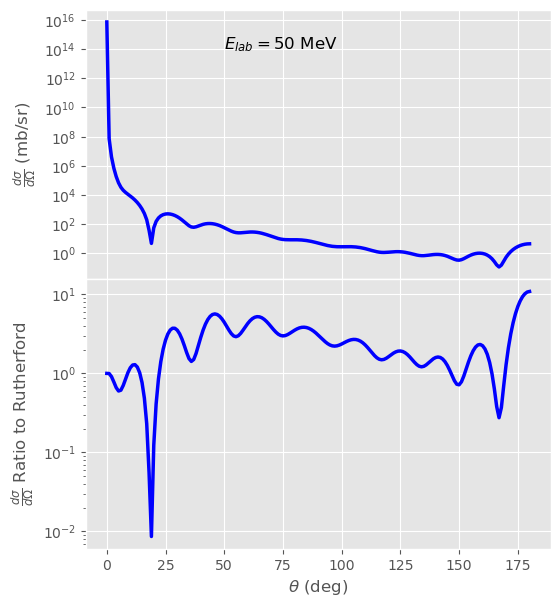

In [174]:
# Plot the results
angles_deg = results_df.index.to_numpy()
diff_xs_mb_per_sr = results_df["differential_xs_absolute_mb_per_sr"].to_numpy()
diff_xs_r2r = results_df_r2r["differential_xs_ratio_to_rutherford"].to_numpy()

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles_deg, diff_xs_mb_per_sr, lw=2.5, color='blue')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)


ax2.plot(angles_deg, diff_xs_r2r, lw=2.5, color='blue')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.text(50.0, 1e14, r"$E_{lab} = 50$ MeV",
        fontsize=FONTSIZE, color='black')


plt.show()


Great! These look nice. 

Let's check our {{bfrescox}} results against a standard {{frescox}} installation. Let's load the benchmark results and visualize them against our {{bfrescox}} calculation. Let's make a plot comparing the two 

In [154]:
# We can benchmark our results against the results obtained from a standard Frescox installation
# Locate BFrescox test data directory
data_path = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

# Load the baseline cross section
baseline_file = data_path / "Ni78_p_elastic_PointA_differential_xs_baseline.csv"
expected = np.loadtxt(baseline_file, delimiter=",")

Let's make a plot comparing the benchmark and our {{bfrescox}} result and see their absolute difference across the angular range.

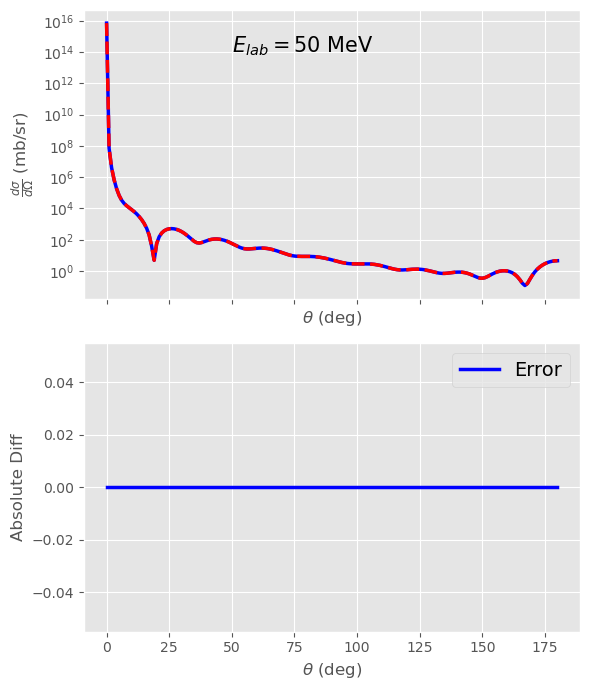

In [179]:
# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size

# Plot differential cross section
ax1.plot(angles_deg, diff_xs_mb_per_sr, lw=2.5, color='blue', label='BFrescox Result')
ax1.plot(expected[:,0], expected[:,1], lw=2.5, color='red', ls='--', label='Baseline from FrescoX')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax1.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)

# Plot differential cross section
ax2.plot(angles_deg, np.abs(diff_xs_mb_per_sr- expected[:,1]), lw=2.5, color='blue', label='Error')
#ax2.set_yscale('log')
ax2.set_ylabel(r"Absolute Diff", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=
               FONTSIZE)

# Add annotation
ax1.text(50.0, 1e14, r"$E_{lab} = 50$ MeV",
         fontsize=15, color='black')

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

Great! Our {{bfrescox}} calculations match the benchmark results!

## Alternative results parsing
You could also parse your own results directly from the desired fort file with a function. For example for fort.16, the {{bfrescox}} package includes a low-level function that loads a significant amount of results not shown above.  Users can access some of this data directly using:

In [180]:
results = bfrescox.parse_fort16(Path("fort.16"))
display(results["channel_1"].head())

,Theta,sigma
0,0.01,1.0000
1,1.00,0.9956
2,2.00,0.9106
3,3.00,0.7792
4,4.00,0.6609
